# 볼린저 밴드

In [3]:
# 볼린저 밴드
# 어떠한 종목의 가격의 과매수,과매도 상태 확인 가능
# 중심선(이동평균선 : 평균)
# 상단선 : 표준편차*2 를 더한 값
# 하단선 : 표준편차*2 를 뺀 값

import FinanceDataReader as fdr
df = fdr.DataReader("005930")

window = 20
std = 2

df["MiddleBand"] = df["Close"].rolling(window).mean()   # 중심선. 단순한 이동평균선
df["Std"] = df["Close"].rolling(window).std()

df["UpperBand"] = df["MiddleBand"] + df["Std"] * std
df["LowerBand"] = df["MiddleBand"] - df["Std"] * std
df

,Open,High,Low,Close,Volume,Change,MiddleBand,Std,UpperBand,LowerBand
Date,,,,,,,,,,
2013-04-16,30100,30640,30020,30560,371037,NaN,NaN,NaN,NaN,NaN
2013-04-17,31320,31320,30280,30360,209822,-0.006545,NaN,NaN,NaN,NaN
2013-04-18,30400,30440,29619,29660,267168,-0.023057,NaN,NaN,NaN,NaN
2013-04-19,29299,29839,29100,29500,314080,-0.005394,NaN,NaN,NaN,NaN
2013-04-22,29800,30059,29299,30060,186717,0.018983,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-06-30,61200,61200,59800,59800,17110294,-0.016447,59050.0,1360.147051,61770.294102,56329.705898
2025-07-01,60400,61100,60200,60200,13650991,0.006689,59250.0,1204.159458,61658.318916,56841.681084
2025-07-02,60200,60900,59800,60800,15047951,0.009967,59450.0,1103.821114,61657.642229,57242.357771


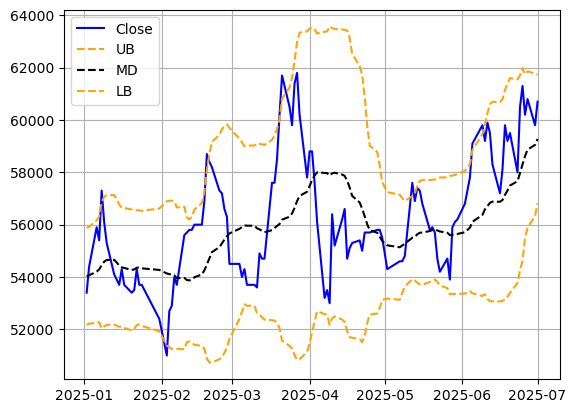

In [7]:
import matplotlib.pyplot as plt

df2 = df[df.index.year >= 2025]

plt.plot(df2.index, df2['Close'], color = 'b')
plt.plot(df2.index, df2['UpperBand'], color = 'orange', linestyle = "--")
plt.plot(df2.index, df2['MiddleBand'], color = 'k', linestyle = "--")
plt.plot(df2.index, df2['LowerBand'], color = 'orange', linestyle = "--")

plt.grid()
plt.legend(['Close', 'UB', 'MD', 'LB'])
plt.show()

# 노란색 선을 벗어나는건 확률이 매우 낮은 경우이므로 매수신호/매도신호로 삼는다 

In [8]:
def get_bollinger_bands(df, window = 20, std = 2):
    
    df["MiddleBand"] = df["Close"].rolling(window).mean()   # 중심선. 단순한 이동평균선
    df["Std"] = df["Close"].rolling(window).std()
    
    df["UpperBand"] = df["MiddleBand"] + df["Std"] * std
    df["LowerBand"] = df["MiddleBand"] - df["Std"] * std
    return df

In [12]:
# 볼린저 밴드 지표를 기준으로 주가가 어느 위치에 있는지를 숫자(1~4)로 분류해주는 함수

def get_bollinger_band_position(df, window = 20, std = 2):

    df = df.copy()
    df['middle'] = df['Close'].rolling(window).mean()
    df['upper'] = df['middle'] + std * df['Close'].rolling(window).std()
    df['lower'] = df['middle'] - std * df['Close'].rolling(window).std()

    cond = [
        df['Close'] > df['upper'],      # 종가가 상단 밴드보다 위에 있음 → 가장 높은 위치 (4)
        df['Close'] > df['middle'],     # 종가가 중심선보다 위에 있음 (3)
        df['Close'] > df['lower']       # 종가가 하단 밴드보다 위에 있음 (2)
    ]

    choice = [4, 3, 2]

    df['bb_pos'] = np.select(cond, choice, default=1)      # 종가가 하단 밴드보다 아래에 있음 (1)
    df['bb_pos'] = df['bb_pos'].fillna(0)
    return df['bb_pos']

In [19]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from backtesting import Backtest, Strategy
from backtesting.lib import crossover

def bollinger(data, n=20, std=2):
    s = pd.Series(data)
    middle = s.rolling(n).mean()
    std_band = s.rolling(n).std()
    upper = middle + std * std_band
    lower = middle - std * std_band
    return upper, middle, lower

# BackTesting
class BB(Strategy):
    bb_window = 20
    bb_std = 2

    stop_pct = 5 

    def init(self):
        self.upper, self.middle, self.lower = self.I(bollinger, self.data.Close, self.bb_window, self.bb_std)

    def next(self):
        current_price = self.data.Close[-1] 
        if current_price < self.lower[-1] and not self.position:
            stop_price = current_price * (1 - self.stop_pct / 100)  # 가장 최신 데이터 가져와서  하단보다도 가격 낮고 not position이면 사겠다 
            self.buy(sl = stop_price)                  # 5% 빠지면 손해가 나더라도 그냥 판다
        elif self.upper[-1] < current_price and self.position:
            self.position.close()

df = fdr.DataReader("005930")

bt = Backtest(df, BB, cash = 1000000, commission=0.002)
stats = bt.run()
stats

Backtest.run:   0%|          | 0/2980 [00:00<?, ?bar/s]

Start                     2013-04-11 00:00:00
End                       2025-07-01 00:00:00
Duration                   4464 days 00:00:00
Exposure Time [%]                    40.76667
Equity Final [$]                  1200761.627
Equity Peak [$]                   1391484.067
Commissions [$]                    234494.873
Return [%]                           20.07616
Buy & Hold Return [%]               100.66007
Return (Ann.) [%]                      1.5487
Volatility (Ann.) [%]                 16.2954
CAGR [%]                              1.03817
Sharpe Ratio                          0.09504
Sortino Ratio                         0.14645
Calmar Ratio                          0.04558
Alpha [%]                           -17.69778
Beta                                  0.37526
Max. Drawdown [%]                   -33.97961
Avg. Drawdown [%]                    -7.42383
Max. Drawdown Duration     1373 days 00:00:00
Avg. Drawdown Duration      169 days 00:00:00
# Trades                          